# CIFAR10图像分类任务

### 1. 导包

In [7]:
import torch
import torch.nn as nn  # 神经网络模块
import torch.optim as optim  # 优化器
import torchvision  # 图像处理工具
import torchvision.transforms as transforms  # 数据预处理
from torch.utils.data import DataLoader  # 数据加载器
from datetime import datetime # 时间
import time

### 2. 获取数据

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# 如果没下载数据集的话，将download调成True
trainset = torchvision.datasets.CIFAR10(root='./data5', train=False, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data5', train=False, download=False, transform=transform)

In [9]:
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### 模型结构，自己搭建简单模型

In [10]:
class TestNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(TestNet, self).__init__()
        # 特征提取部分
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate/2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # 分类器部分
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate/2),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 增强预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [11]:
net = TestNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

TestNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 开始训练模型
start_time = time.time()  # 记录训练开始时间
for epoch in range(200):  # 训练 200 个 epoch
    running_loss = 0.0  # 初始化每轮的累计损失
    for i, data in enumerate(trainloader, 0):  # 遍历训练数据加载器
        inputs, labels = data[0].to(device), data[1].to(device)  # 将输入数据和标签移动到指定设备（如 GPU）
        optimizer.zero_grad()  # 清零梯度，避免梯度累积
        outputs = net(inputs)  # 前向传播，计算模型输出
        loss = criterion(outputs, labels)  # 计算损失值
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新模型参数
        running_loss += loss.item()  # 累加损失值

        # 每 100 批次打印一次详细信息
        if i % 100 == 99:  
            avg_loss = running_loss / 100  # 计算平均损失
            print(f'[Epoch {epoch + 1}/{100}, Batch {i + 1}/{len(trainloader)}] '
                  f'Average Loss: {avg_loss:.4f} | '
                  f'Current Batch Loss: {loss.item():.4f} | '
                  f'Running Loss: {running_loss:.4f}')
            running_loss = 0.0  # 重置累计损失

end_time = time.time()  # 记录训练结束时间
elapsed_time = end_time - start_time  # 计算总耗时
print(f'Finished Training. Total time taken: {elapsed_time:.2f} seconds')

# 保存模型
timestamp = datetime.now().strftime("%y-%m-%d-%H-%M-%S")  # 获取当前时间戳
model_name = f"CIFAR10Net-{timestamp}.pth"
torch.save(net.state_dict(), model_name)
print(f"Model saved successfully as {model_name}")

[Epoch 1/100, Batch 100/157] Average Loss: 0.0569 | Current Batch Loss: 0.0957 | Running Loss: 5.6926
[Epoch 2/100, Batch 100/157] Average Loss: 0.0546 | Current Batch Loss: 0.1067 | Running Loss: 5.4612
[Epoch 3/100, Batch 100/157] Average Loss: 0.0541 | Current Batch Loss: 0.0189 | Running Loss: 5.4121
[Epoch 4/100, Batch 100/157] Average Loss: 0.0529 | Current Batch Loss: 0.0571 | Running Loss: 5.2875
[Epoch 5/100, Batch 100/157] Average Loss: 0.0509 | Current Batch Loss: 0.0629 | Running Loss: 5.0866
[Epoch 6/100, Batch 100/157] Average Loss: 0.0437 | Current Batch Loss: 0.0154 | Running Loss: 4.3737
[Epoch 7/100, Batch 100/157] Average Loss: 0.0600 | Current Batch Loss: 0.0297 | Running Loss: 5.9992
[Epoch 8/100, Batch 100/157] Average Loss: 0.0513 | Current Batch Loss: 0.0100 | Running Loss: 5.1297
[Epoch 9/100, Batch 100/157] Average Loss: 0.0510 | Current Batch Loss: 0.0886 | Running Loss: 5.0966
[Epoch 10/100, Batch 100/157] Average Loss: 0.0502 | Current Batch Loss: 0.0235 | 

In [32]:
# 初始化正确预测的数量和测试数据的总数
correct_predictions = 0
total_samples = 0

# 禁用梯度计算，节省内存和计算资源
with torch.no_grad():
    for data in testloader:  # 遍历测试数据加载器
        images, labels = data[0].to(device), data[1].to(device)  # 将图像和标签移动到指定设备
        outputs = net(images)  # 前向传播，获取模型的输出
        _, predicted_labels = torch.max(outputs.data, 1)  # 获取预测的类别（概率最高的类别）
        total_samples += labels.size(0)  # 累加测试数据的总数
        correct_predictions += (predicted_labels == labels).sum().item()  # 累加正确预测的数量

# 计算准确率
accuracy = 100 * correct_predictions / total_samples
print(f'Accuracy: {accuracy:.2f}%')  # 打印准确率

Accuracy: 99.74%


### 混淆矩阵

In [1]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# 
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data[0].to(device), data[1].to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
# 
# cm = confusion_matrix(all_labels, all_preds)
# sns.heatmap(cm, annot=True, fmt='d')
# plt.show()

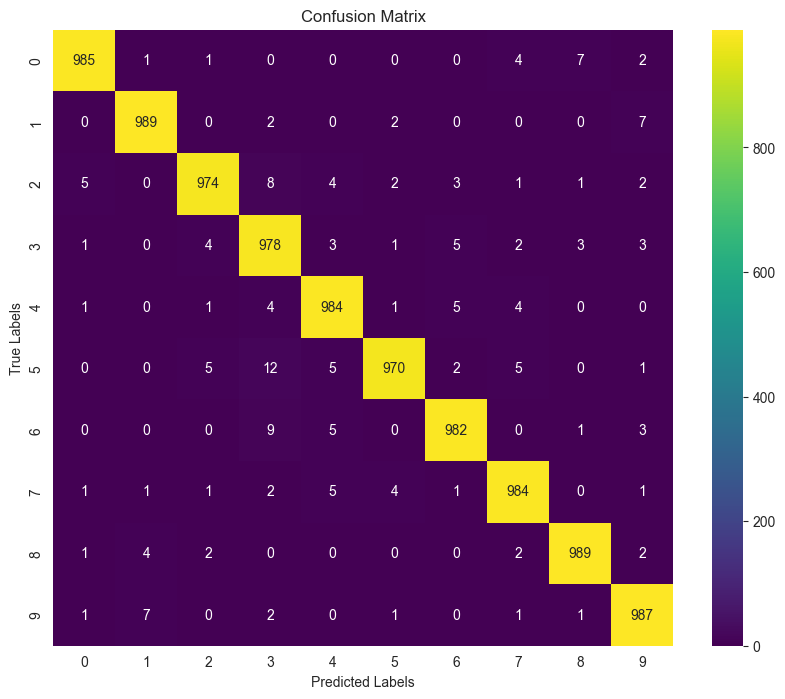

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, all_labels = [], []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')  # 使用viridis配色方案
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 收集所有样本的预测概率

In [24]:
import numpy as np
from torch.nn.functional import softmax

all_preds = []  # 保存所有样本的预测概率
all_labels = []  # 保存所有真实标签

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        probabilities = softmax(outputs, dim=1)  # 转换为概率 [batch_size, 10]
        all_preds.append(probabilities.cpu().numpy())  # 转移到CPU并转为numpy
        all_labels.append(labels.cpu().numpy())

# 合并所有batch的结果
all_preds = np.concatenate(all_preds, axis=0)  # 形状 [N, 10]
all_labels = np.concatenate(all_labels, axis=0)  # 形状 [N, ]

### 精确率召回率曲线

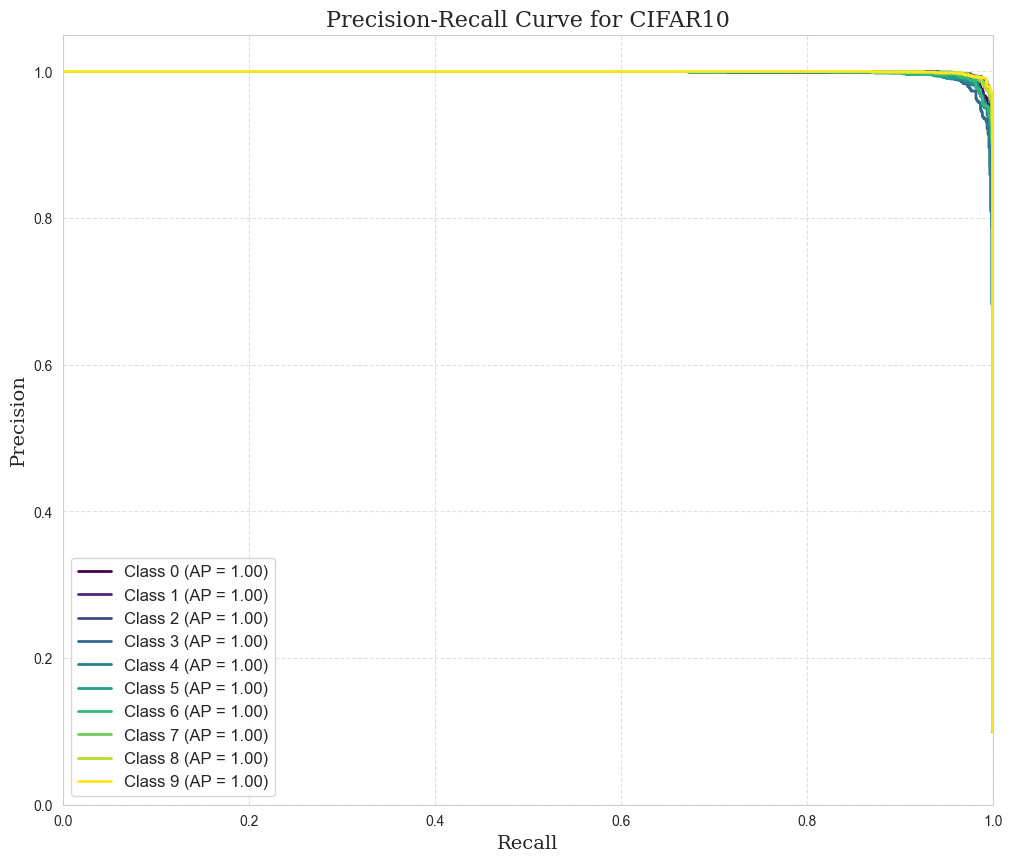

In [27]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

n_classes = 10  # CIFAR10数据集有10个类别

# 初始化字典来存储每个类别的精确度、召回率和平均精确度
precision = dict()
recall = dict()
average_precision = dict()

# 遍历所有类别
for i in range(n_classes):
    # 提取第i类的概率作为预测分数，并生成对应的二分类标签
    precision[i], recall[i], _ = precision_recall_curve(
        (all_labels == i).astype(int), 
        all_preds[:, i]
    )
    average_precision[i] = auc(recall[i], precision[i])

# 设置图形的大小和分辨率
plt.figure(figsize=(12, 10), dpi=100)

# 设置颜色循环，确保每个类别都有不同的颜色
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

# 设置x轴和y轴的标签
plt.xlabel('Recall', fontsize=14, fontfamily='serif')
plt.ylabel('Precision', fontsize=14, fontfamily='serif')

# 设置图形标题
plt.title('Precision-Recall Curve for CIFAR10', fontsize=16, fontfamily='serif')

# 添加图例，使用较大的字体和框架
plt.legend(loc='best', fontsize=12, frameon=True)

# 设置网格线，增加图表的可读性
plt.grid(True, linestyle='--', alpha=0.6)

# 设置坐标轴的范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# 保存图形到文件，如果需要
plt.savefig('precision_recall_curve.png', bbox_inches='tight')

# 显示图形
plt.show()

### ROC

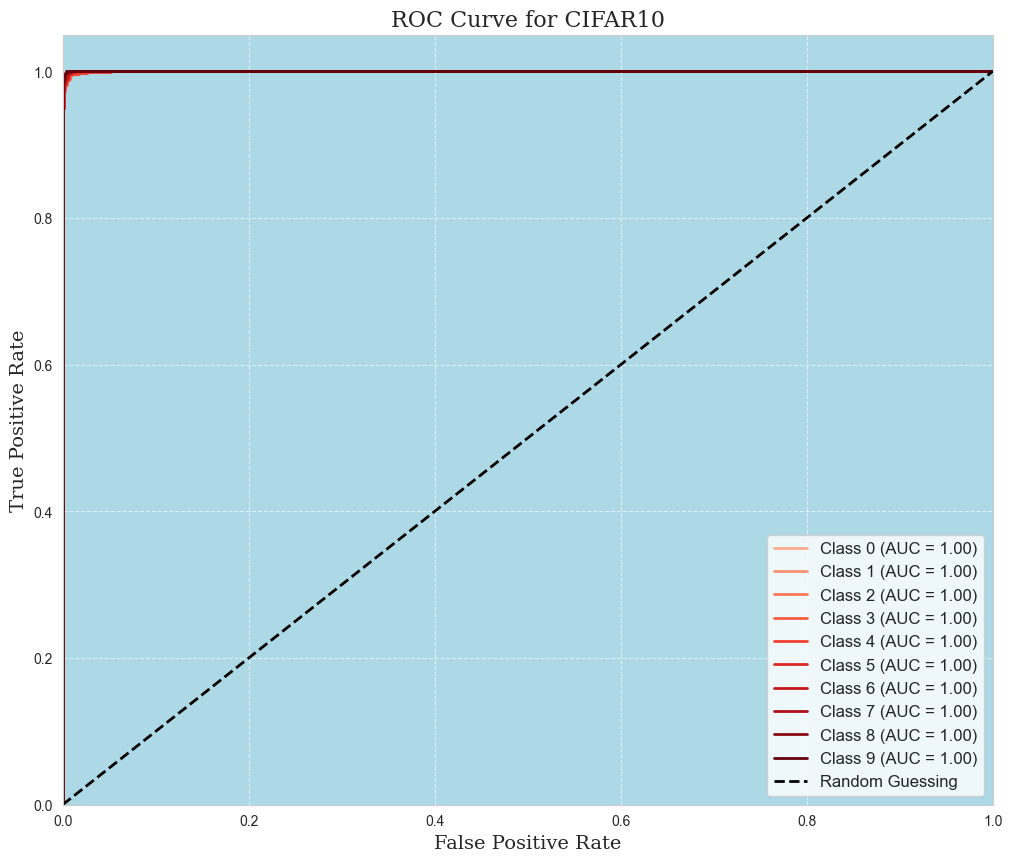

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# ROC曲线
all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
all_preds_binarized = all_preds
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_preds_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 设置图形的大小和分辨率
plt.figure(figsize=(12, 10), dpi=100)

# 设置背景颜色为浅蓝色
plt.gca().set_facecolor('#ADD8E6')  # RGB格式的浅蓝色

# 设置颜色循环，使用红色系的不同深浅
colors = plt.cm.Reds(np.linspace(0.3, 1, n_classes))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# 添加对角线，表示随机猜测的性能，使用黑色虚线
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')

# 设置x轴和y轴的标签
plt.xlabel('False Positive Rate', fontsize=14, fontfamily='serif')
plt.ylabel('True Positive Rate', fontsize=14, fontfamily='serif')

# 设置图形标题
plt.title('ROC Curve for CIFAR10', fontsize=16, fontfamily='serif')

# 添加图例，使用较大的字体和框架
plt.legend(loc='best', fontsize=12, frameon=True)

# 设置网格线，增加图表的可读性，使用白色虚线
plt.grid(True, linestyle='--', alpha=0.6, color='white')

# 设置坐标轴的范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# 保存图形到文件，如果需要
plt.savefig('roc_curve_red.png', bbox_inches='tight')

# 显示图形
plt.show()